#データの取得(分類)

In [ ]:
# 勾配ブースティング -> 「決定木分析」を応用した機械学習の手法。Best of 教師あり学習、と呼んでも良いような手法で、簡単で高性能なAIモデルが作れる場合が多い
# 数字やカテゴリーなどを分類,回帰を予測する場合とりあえず勾配ブースティングすれば良い。ランダムフォレストと似ている。

# アンサンブル学習 -> 複数のモデル(学習器)を融合させて1の学習モデルを生成する方法
# 3つの手法が存在する
# 1,バギング(並列的に学習) -> ランダムフォレストはこれ。いっぱい作って最後に多数決を取って分類や平均を算出する
# 2,ブースティング(前の弱学習器の結果を次の学習データに反映させる) -> 1回決定木を作り、結果を確認後、修正部分があれば、調整して決定木を作る。その決定木の結果を確認後、修正部分があれば、調整して決定木を作るの繰り返し(逐一更新)

# 勾配ブースティングが結果的に優れる場合が多い

In [2]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

X = dataset.data 
y = dataset.target

#XGboostライブラリ導入

In [3]:
import xgboost as xgb
model_XGB = xgb.XGBClassifier(objective="binary:logistic",max_depth=10) #２値分類する場合は,引数にobjective="binary:logistic(logistic回帰)"を入れる(logisticのほか以外もある)

#データ分割(Cross Validatoin)

In [ ]:
# 一般的にはhold out法 -> いまあるデータを比率で分けるのは同じだが、1回目の学習が終わったら、別の部分でまた学習用データとテストデータを移動させて学習させる
# 分割数は何でも良い,データを満遍なく散らせて学習させることて平均したらテストデータの偏りを少なくすることができる
# 処理時間はかかるが、できるのならする

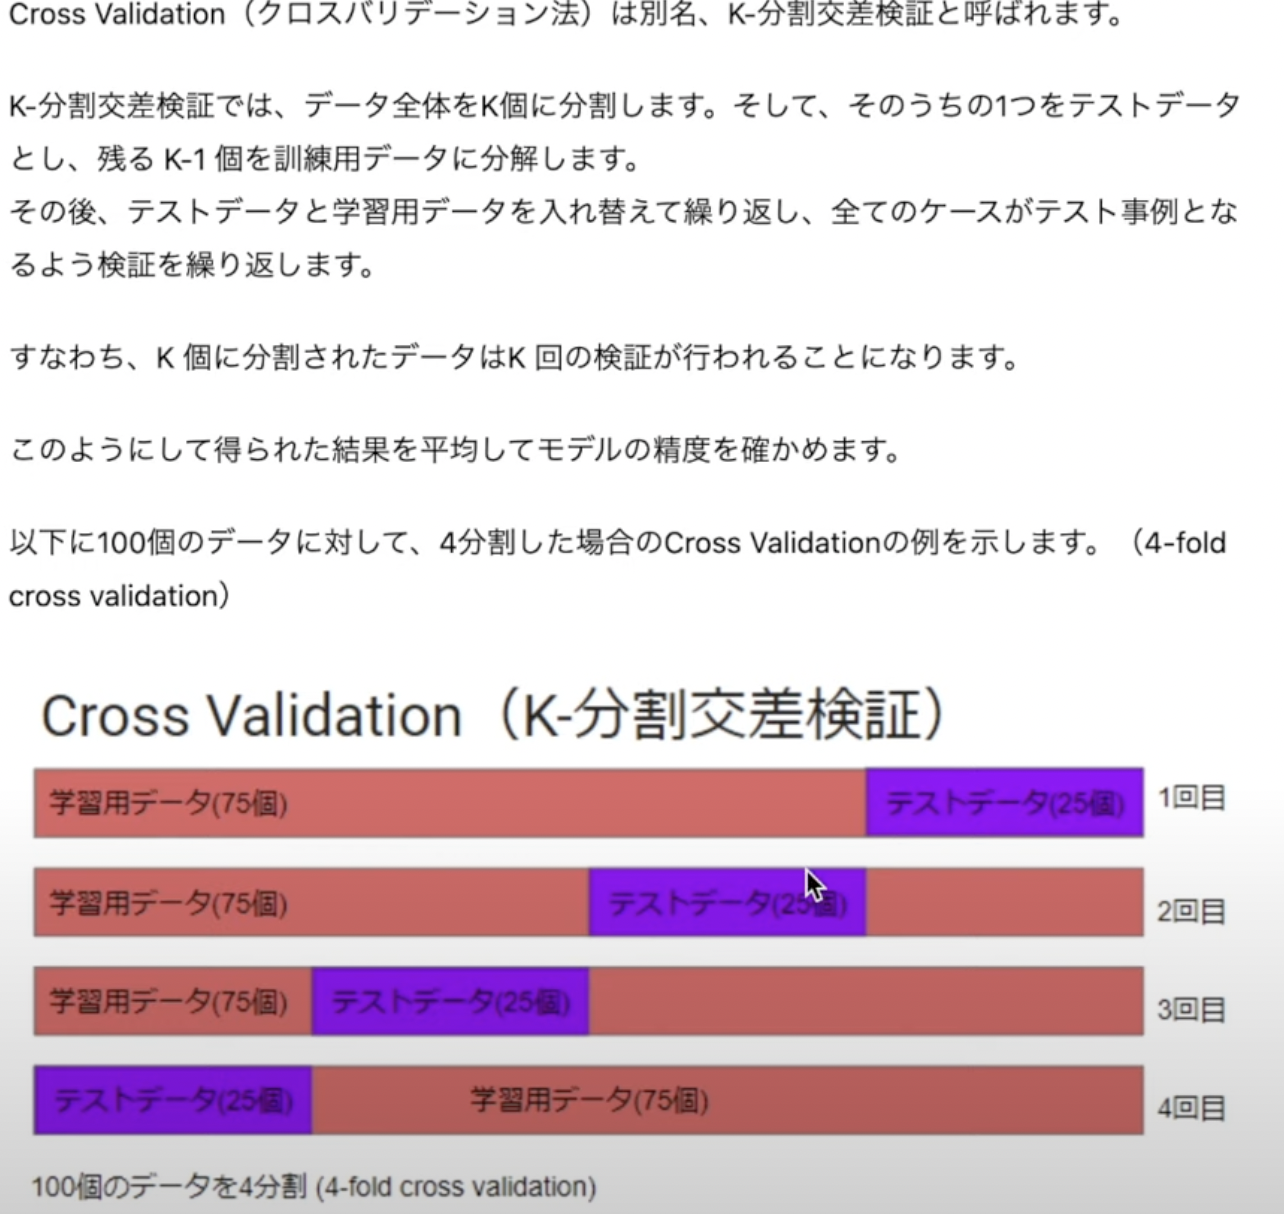

In [6]:
from sklearn.model_selection import cross_validate,KFold

# 交差検証で何分割するのか指定する(5~10ぐらい,データによるが実験すれば良い)
kf = KFold(n_splits=5,shuffle=True) #n_splits(分割数)=5, shuffle(データをランダムにする)=True
score = cross_validate(model_XGB,X,y,cv=kf,scoring=["accuracy"],return_estimator=True) 
#どのモデルを使うか,説明変数,目的変数,cv(どのように分割するのか),どのような評価指標を使うのか(scoring=["accuracy"] ->　評価指標が本当にaccuraryで良いのかよく考える,ほかもあるので要検討)を指定
#["accuracy"]鉤括弧になっている理由は評価指標を複数指定できるから,return_estimator=True重要な変数が何だったのかを結果を返してくれる

In [7]:
# 結果確認
score #return_estimator=Trueにすると細かい結果を得ることができる
'test_accuracy' ->大事な部分,
↑の結果 -> 0.95614035, 0.98245614, 0.95614035, 0.92982456, 0.94690265
# 交差検証で5分割したため結果5個になっている,今回はテストデータの正解率が高い,↑の数字の平均がこのモデルの精度として考えて良い

{'estimator': [XGBClassifier(max_depth=10),
  XGBClassifier(max_depth=10),
  XGBClassifier(max_depth=10),
  XGBClassifier(max_depth=10),
  XGBClassifier(max_depth=10)],
 'fit_time': array([0.31479788, 0.19884849, 0.18476081, 0.19876456, 0.34934235]),
 'score_time': array([0.0017941 , 0.00159836, 0.00155401, 0.00150561, 0.01152539]),
 'test_accuracy': array([0.95614035, 0.98245614, 0.95614035, 0.92982456, 0.94690265])}

In [8]:
score['test_accuracy'].mean()
# 0.9542928116752059 の精度を持つ学習器を生成できた,高め性能,どのような決定木が作られたのかわかりえない
#だが、どの変数が大事だったのかは見ることができる

0.9542928116752059

In [14]:
# これをすることでestimatorにどの変数が重要だったか知れる
# score["estimator"][0].feature_importances_ ,結果の0番目を指定して,重要順で説明変数が格納されている
# [0]を変えれば結果も変わる(0~4)
import pandas as pd

# 5回したのでその平均を算出する
import numpy as np

#[score["estimator"][i].feature_importances_ for i in range(5)] #リストの中に先ほどの5つが入る
mean_score = np.mean([score["estimator"][i].feature_importances_ for i in range(5)],axis=0) #axis=0行で平均
# これで重要度を確認できる 

pd.DataFrame({"説明変数":dataset.feature_names, "重要度":mean_score}).sort_values("重要度",ascending=False)
#整理されたもの

,説明変数,重要度
22,worst perimeter,0.240249
20,worst radius,0.196411
7,mean concave points,0.124334
27,worst concave points,0.123423
23,worst area,0.089865
26,worst concavity,0.022468
1,mean texture,0.021229
21,worst texture,0.017759
11,texture error,0.013522
6,mean concavity,0.011829


In [15]:
mean_score

array([0.00784191, 0.02122945, 0.00552983, 0.01176551, 0.00668317,
       0.00741311, 0.01182859, 0.1243338 , 0.00483578, 0.00667498,
       0.00940701, 0.01352179, 0.00694823, 0.0113558 , 0.0033624 ,
       0.00642881, 0.00915965, 0.00589189, 0.00390259, 0.00509188,
       0.1964111 , 0.01775865, 0.24024872, 0.08986545, 0.00724983,
       0.00516698, 0.02246762, 0.1234226 , 0.00529611, 0.00890676],
      dtype=float32)

#データの取得(回帰) - 分類とノリは同じ

In [16]:
from sklearn.datasets import load_boston 
dataset = load_boston()

X = dataset.data 
y = dataset.target

import xgboost as xgb
model_XGB = xgb.XGBRegressor(objective="reg:squarederror",max_depth=10) #回帰場合は,引数にobjective="reg:squarederror"を入れる(squarederrorのほか以外もある)

from sklearn.model_selection import cross_validate,KFold

kf = KFold(n_splits=5,shuffle=True)
score = cross_validate(model_XGB,X,y,cv=kf,scoring=["neg_mean_absolute_error"],return_estimator=True) #"accuracy"は分類の時の評価指標

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [18]:
score['test_neg_mean_absolute_error'].mean()
# 結果(-2.1966459084038505)の-は仕様でついてしまう(数字*-1), 0に近いほど良い

-2.1966459084038505

In [19]:
import pandas as pd
import numpy as np

mean_score = np.mean([score["estimator"][i].feature_importances_ for i in range(5)],axis=0) #axis=0行で平均
pd.DataFrame({"説明変数":dataset.feature_names, "重要度":mean_score}).sort_values("重要度",ascending=False)

# 数値やカテゴリー変数の場合はとりあえず、交差検証をしてGradient_Boostingを1個目としてすれば無難(有用で実践的),ほかの手法でも考えてみる

,説明変数,重要度
12,LSTAT,0.559752
5,RM,0.246067
7,DIS,0.048008
4,NOX,0.034771
10,PTRATIO,0.033885
9,TAX,0.018385
0,CRIM,0.014857
8,RAD,0.012583
2,INDUS,0.011273
6,AGE,0.009701
